## **はじめに**

---

まずはいつも通りGoogle colaboratory上にD-Wave Systemsが提供しているOcean SDKをインストールするところから始めましょう。


In [ ]:
pip install dwave-ocean-sdk

またシミュレーターとしてOpenJijを利用する場合にはこちらも用意しておきましょう。

In [ ]:
pip install openjij

そしてご自身がお持ちのAPI tokenと接続先のendpointを設定します。

In [ ]:
token = '**'
endpoint = 'https://cloud.dwavesys.com/sapi/'

さて今回は様々な組合せ最適化問題に対応するQUBO行列を作ってみましょう！
正直に言って量子アニーリングマシンはQUBO行列さえ用意すれば様々な問題を解くことができますよ！と言っても、どうやってQUBO行列にすれば良いのか、とかどういうふうに考えたら良いのか、とか。
組合せ最適化問題について勉強してからかな？とか、かなりハードル高いです。

そこで今回は量子アニーリングマシンの定式化でよくやる基本作法を学び、それらを組み合わせて色々な問題に対応させていくということを紹介します。

### 量子アニーリングマシンで解ける組合せ最適化問題

量子アニーリングマシンで考える組合せ最適化問題は、マシンの性質によってQUBO行列を利用した二次関数のみ解くことができます。
\begin{equation}
E({\bf x}) = \sum_{i=1}^N \sum_{j=1}^N Q_{ij} x_i x_j
\end{equation}

量子アニーリングの解説やWebの情報等を調べると必ずそうした記述があります。そのせいでQUBO行列に意識が行きがちです。それよりも**大事なことは、二次関数である**ということです。
二次関数と聞けば、僕にでも私にでもできるのではないか？と考えることができるのではないでしょうか。

そのため最初は**できるだけ二乗を作る意識**で、解くべき組合せ最適化問題を考えましょう。

二次関数で教わったことといえば最大値や最小値は頂点のところにあるよ、ということを思い出すことができるのではないでしょうか。
最小化問題を考えるという場合であれば、下に凸の次のような二次関数であれば簡単そうです。

In [ ]:
import numpy as np
a = 0.5
x = np.linspace(0,10,11)
y = a*x**2

ここでnp.linspace()を用いて、$0$から始まり、$10$でおわる$11$個の数列を用意しました。
つまり$x=(0,1,2,3,,,,10)$です。
その数列をxに格納しています。
それに対してyはaをかけて、xを二乗していますね。aは$0.5$としていますが、他の値にしたりして形を変えても結構ですよ。
このxとyによるグラフを見てみましょう。

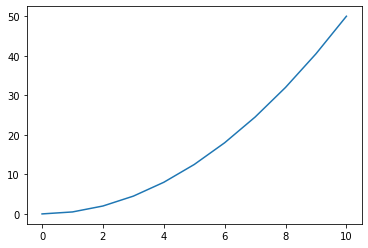

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x,y)
plt.show()

おなじみの放物線ができました。片側だけなので寂しいですか？
それでは頂点を動かしてみましょう。


In [ ]:
b = 3
y = a*(x-b)**2

ここでbの値によって二次関数が平行移動するようにします。b=3ですから右に3ズレるはずです。

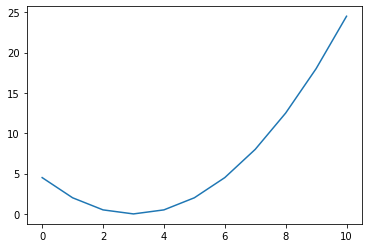

In [ ]:
plt.plot(x,y)
plt.show()

確かに右にずれて、下に凹んだ頂点が見えるようになりました。左右に伸びた放物線も見ると都ができました。
もっと鋭いものを描きたかったらaの値を変えてみましょう。
こうしたグラフを描くのもプログラミングの威力ですぐに描くことができます。
この場合は最小値が頂点のところの$3$にくるはずというのはすぐにわかります。

量子アニーリングマシンでもそうした結果を出すことはできるでしょうか。

### 量子アニーリングマシンで整数値を扱う

ただ問題は量子アニーリングマシンでは$x_i=0$または$1$をとる二値の変数のみが利用できました。それでは答えが$3$のような整数になるということはありません。
よくよく考えてみると$0$と$1$しか扱えないというのはなかなか不自由です。
整数値くらい使えるようにならないものでしょうか。
そのために幾つかの変数を足し合わせて、その合計値で整数を示すようにしましょう。
例えば
\begin{equation}
x = \sum_{i=1}^N x_i
\end{equation}
というように二値をとる$x_i$を足し算していけば、$x$は最小で$0$（全ての$x_i$が$0$をとる場合）となり、$x$は最大で$N$（全ての$x_i$が$1$をとる場合）となります。
これで最小$0$、最大$N$の整数を量子アニーリングマシンの中で動作する量子ビットで表すことができました。
この結果をそのまま、上記の二次関数に入れてみましょう。
\begin{equation}
y = a\left(\sum_{i=1}^N x_i - b \right)^2
\end{equation}
ここで二乗というのは同じものを二回かけるという意味であるから次のような意味を持ちます。
\begin{equation}
y = a\left(\sum_{i=1}^N x_i - b \right)\left(\sum_{j=1}^N x_j - b \right)
\end{equation}
ここで和をとる記号のシグマ記号が$i$が$1$から$N$までその値を変えて足し算されるということを思い出すと、別に文字は$i$でなくてもなんでも良い。どうせ$1$から$N$までの値に変わるので。そこで$i$の代わりに2回目の登場時には$j$を利用することにしました。
これをそのまま展開すると、
\begin{equation}
y = a \sum_{i=1}^N \sum_{j=1}^N x_ix_j - 2ab \sum_{i=1}^N x_i + ab^2
\end{equation}
という結果を得ます。

この結果を見てみると、QUBO行列が現れていることに気づきます。
第一項はそのままですね。係数$a$がQUBO行列に代わります。
さらに第二項から$-2ab$が$x_i^2=x_i$であることに注意すると、$x_ix_i$の係数として追加されます。第三項はあくまで定数項で最小化には関係しないもの、$x_i$には依存しないもので放っておきましょう。

さてそれではQUBO行列を作るコードを書いてみましょう。ここでは$N=10$とします。
つまり最小$0$、最大$10$となるような整数の範囲で、二次関数の最小化を考えます。
答えはもちろん$b=3$になるはずです。

In [ ]:
N = 10
QUBO = np.zeros(N**2).reshape(N,N)

np.zeros()で全成分が$0$の数列を100個作ります。それを$10 \times 10$の行列に変形して並べます。
さてこれに第一項の結果を入れてみましょう。

In [ ]:
for i in range(N):
  for j in range(N):
    QUBO[i][j] = a

次は**第二項を追加**しましょう。
$x_ix_i$の係数だけですから、QUBO[i][i]と指定して、対角成分だけに追加されるようにしましょう。

In [ ]:
for i in range(N):
  QUBO[i][i] = QUBO[i][i] - 2*a*b


これで準備完了です。二次関数の展開からQUBO行列が決まり、量子アニーリングマシンに投じる形に処理することができました。

それでは前回の復習です。量子アニーリングマシンに問題を投じましょう。
まずはDWaveSampler()で準備をします。

In [ ]:
from dwave.system import DWaveSampler, EmbeddingComposite

dw_sampler = DWaveSampler(solver='Advantage_system1.1', token=token)
sampler = EmbeddingComposite(dw_sampler)

ここでは埋め込みが自動的に決まり、そのまま量子アニーリングマシンに問題が投じられるEmbeddingComposite()を利用しました。

In [ ]:
sampleset = sampler.sample_qubo(QUBO,num_reads=10)
print(sampleset.record)

[([1, 0, 0, 1, 0, 1, 0, 0, 0, 0], -4.5, 1, 0.)
 ([0, 0, 1, 0, 0, 0, 0, 1, 0, 1], -4.5, 1, 0.)
 ([1, 1, 0, 0, 0, 0, 0, 0, 1, 0], -4.5, 1, 0.)
 ([0, 1, 0, 0, 1, 0, 0, 1, 0, 0], -4.5, 1, 0.)
 ([0, 0, 1, 0, 0, 1, 0, 0, 1, 0], -4.5, 1, 0.)
 ([0, 0, 0, 1, 1, 0, 1, 0, 0, 0], -4.5, 2, 0.)
 ([0, 0, 0, 1, 0, 0, 0, 1, 1, 0], -4.5, 1, 0.)
 ([0, 0, 0, 0, 1, 0, 1, 1, 1, 0], -4. , 1, 0.)
 ([0, 1, 0, 0, 0, 1, 1, 1, 0, 0], -4. , 1, 0.)]


結果を見ると、$x_i=1$となっているのは合計して$3$つになっているはずです。
たまにしくじっているものもあるかもしれません。
ちゃんと二次関数の頂点のところに、最小値を持つところに結果を出してくれています。
-4.5というエネルギー値を出しています。それは$9a$と足算をするとぴったり$0$になります。
つまり二次関数の最小値である$0$です。ちゃんと答えになっていますね。

### 数式からQUBO行列にするライブラリpyQUBO


二次関数からなる数式からQUBO行列を得ることができるということがわかりました。
展開して丁寧にプログラムに起こすことでQUBO行列に相当する部分を取り出すことができます。
しかし計算間違いや、プログラムの間違いがあり得ますので、それを排除するために便利なライブラリがあります。
リクルートコミュニケーションズ作成のpyQUBOです。
D-Wave Ocean SDKにも搭載されているため、そのまま利用することができます。

pyQUBOの使い方は、まずどんな文字で数式を表すのか、ということを宣言します。

In [ ]:
from pyqubo import Array

# バイナリ変数
x = Array.create(name='x', shape=(N), vartype='BINARY')
print(x)

Array([Binary(x[0]), Binary(x[1]), Binary(x[2]), Binary(x[3]), Binary(x[4]), Binary(x[5]), Binary(x[6]), Binary(x[7]), Binary(x[8]), Binary(x[9])])


まずはpyQUBOからArrayというクラスを呼び出します。
Array.create()で数式で使われる文字式として、xを用意します。
そのxはshape=NとありますようにN個の文字式を用意します。その文字は'BINARY'ですから、2値の$0$または$1$をとるよ、と教えています。ここで'SPIN'という選択をすると$x_i=-1$または$x_i=+1$を取るタイプにも変えられます。このタイプはイジング変数と呼びます。
狙い通りN=10個のBinary(x[i])が用意できたかと思います。これが$x_i$のことだと考えてください。

これを用いて数式を書くかのようにプログラムすることができます。
例えば先程の二次関数を書いてみましょう。

In [ ]:
y = a*(sum(x)-b)**2

数式のままですよね。sum(x）は$\sum_{i=1}^N x_i$のことです。他はPythonの数式の書き方ですね。$a$をかけたり、$b$をずらしたり、二乗したり。

このコスト関数からQUBO行列への変換は、以下の通りです。

In [ ]:
model = y.compile()
qubo, offset = model.to_qubo()

最初のy.compile()でQUBO行列の変換を行う準備をして、model.to_qubo()により、QUBO行列に変換をすることができます。
実際に見てみましょう。

In [ ]:
print(qubo)

{('x[8]', 'x[8]'): -2.5, ('x[7]', 'x[7]'): -2.5, ('x[1]', 'x[1]'): -2.5, ('x[0]', 'x[0]'): -2.5, ('x[4]', 'x[4]'): -2.5, ('x[2]', 'x[2]'): -2.5, ('x[8]', 'x[2]'): 1.0, ('x[6]', 'x[2]'): 1.0, ('x[8]', 'x[1]'): 1.0, ('x[8]', 'x[0]'): 1.0, ('x[2]', 'x[0]'): 1.0, ('x[8]', 'x[5]'): 1.0, ('x[7]', 'x[5]'): 1.0, ('x[7]', 'x[1]'): 1.0, ('x[0]', 'x[1]'): 1.0, ('x[9]', 'x[7]'): 1.0, ('x[9]', 'x[6]'): 1.0, ('x[7]', 'x[4]'): 1.0, ('x[3]', 'x[2]'): 1.0, ('x[7]', 'x[2]'): 1.0, ('x[8]', 'x[6]'): 1.0, ('x[4]', 'x[2]'): 1.0, ('x[5]', 'x[4]'): 1.0, ('x[3]', 'x[0]'): 1.0, ('x[3]', 'x[3]'): -2.5, ('x[4]', 'x[3]'): 1.0, ('x[9]', 'x[0]'): 1.0, ('x[6]', 'x[1]'): 1.0, ('x[7]', 'x[3]'): 1.0, ('x[6]', 'x[0]'): 1.0, ('x[8]', 'x[3]'): 1.0, ('x[6]', 'x[4]'): 1.0, ('x[3]', 'x[1]'): 1.0, ('x[9]', 'x[2]'): 1.0, ('x[5]', 'x[0]'): 1.0, ('x[2]', 'x[1]'): 1.0, ('x[5]', 'x[5]'): -2.5, ('x[9]', 'x[8]'): 1.0, ('x[9]', 'x[3]'): 1.0, ('x[5]', 'x[2]'): 1.0, ('x[6]', 'x[5]'): 1.0, ('x[6]', 'x[6]'): -2.5, ('x[4]', 'x[0]'): 1.0, (

これを見ると、どの文字とどの文字の間に係数がかかっているのかというdict形式による記述がされています。

これをそのままD-Waveマシンに投じることができます。

In [ ]:
dw_sampler = DWaveSampler(solver='Advantage_system1.1', token=token)
sampler = EmbeddingComposite(dw_sampler)

どのマシンやソルバーを利用するか、埋め込み方法が必要であれば指定したのちに計算を実行してください。
もちろんマシンタイムの節約のためにシミュレータを使うのも良いでしょう。その場合はこちらを使いましょう。

In [ ]:
from openjij import SQASampler
sampler = SQASampler()

pyQUBOではdict形式で問題が記述されているので、そのままOpenJijによるシミュレーターに問題を投入することができます。

In [ ]:
sampleset = sampler.sample_qubo(qubo,num_reads=10)
print(sampleset.record)

[([1, 0, 1, 0, 0, 1, 0, 0, 0, 0], -4.5, 1, 0.)
 ([0, 0, 0, 0, 0, 0, 1, 1, 0, 1], -4.5, 1, 0.)
 ([0, 0, 0, 0, 0, 1, 0, 1, 0, 1], -4.5, 3, 0.)
 ([0, 0, 0, 0, 0, 0, 1, 1, 1, 0], -4.5, 1, 0.)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 1], -4. , 1, 0.)
 ([0, 1, 0, 0, 0, 0, 1, 1, 1, 0], -4. , 1, 0.)
 ([0, 0, 1, 0, 1, 1, 0, 0, 1, 0], -4. , 1, 0.)
 ([0, 0, 1, 0, 0, 1, 0, 1, 1, 0], -4. , 1, 0.)]


同じような結果が出てきましたね。頂点である$b=3$付近のところで答えが出ていると思います。
ちなみにoffsetというのは定数部分として$x$に関係しない定数の値が得られています。みてみると$ab^2=4.5$となるはずです。

In [ ]:
print(offset)

4.5


はいバッチリですね！

### 罰金法

こうした二次関数からQUBO行列を作ることができるのだ、と知っていれば$x_i=0$または$1$をとる二値変数に対して、制限を加えることができます。先程の例では、みんなが知っているような二次関数を利用すれば$x_i$の合計した値が$b$になるようにできるということがわかりました。
逆説的に、合計が$b$となるようにしたい場合には、次のような二次関数を与えれば良いということがわかります。
\begin{equation}
E(x) = \frac{a}{2}\left( \sum_{i=1}^N x_i - b \right)^2
\end{equation}

つまりこうした二次関数は、役割を持っていて、$\sum_{i=1}^N x_i$を$b$にするという条件を満たすためのものであるということになります。
最適化問題では、**何かと何かを等しくしておいてくださいという等式制約条件**を課すことが往々にしてあります。
こうした二次関数の頂点を利用して**等式制約条件を実装する方法を罰金法**と呼びます。

ちなみに足し算ですから、どこが$1$になって所望の数値を与えても良いことに注目すると次のような問題に利用することができます。

### 例題

荷物が複数あり、それらには重さが適当に決められているとする。
その荷物を決められた個数を取り出すとします。
そのときに荷物の総量が最大となる組み合わせを考えよう。

まず荷物の個数を$N=10$としましょう。
そして重さを適当に乱数値で決めておきましょう。

In [ ]:
N = 10
w = np.random.rand(N)
print(w)

[0.28804661 0.92110721 0.72182371 0.13426707 0.72502264 0.93964647
 0.08257674 0.29841768 0.14978464 0.8095039 ]


この荷物の中から重いものを探してくれば答えは自ずからわかりますが、まずは例題として、これを量子アニーリングマシンで解くことを考えてみましょう。
まずは荷物の選択を表す$x_i$という変数を用意しましょう。

In [ ]:
x = Array.create(name='x', shape=N,vartype='BINARY')

次に決められた個数というのを$K=3$としましょう。
3つの荷物を取り出すというわけです。そこで罰金法を利用しましょう。
\begin{equation}
a\left(\sum_{i=1}^N x_i - K \right)^2
\end{equation}
これをpyQUBOを利用して、次のようにコードを書いておきます。

In [ ]:
K = 3
constr = (sum(x)-K)**2

このconstrに罰金法で利用する二次関数を準備しました。$x_i$の合計がKになるようにしています。適当な係数である$a$は後でかけることにします。

次に重さが最大となるように、という点を考慮しましょう。
基本的に最小化問題を解くのが量子アニーリングマシンですが、最大化をしたい場合は、符号をマイナスにします。
罰金法を含め、次のようなコスト関数はいかがでしょうか。
\begin{equation}
E(x) = - \sum_{i=1}^N w_i x_i + a \left(\sum_{i=1}^N x_i - K \right)^2
\end{equation}
第1項では$x_i=1$になるものだけが計算にかかり、その合計が大きくなればなるほど、コスト関数が下がるようになります。つまり重いほどコスト関数的には嬉しいわけです。
第2項は罰金法ですね。
それではコスト関数の第1項をコードで書いてみましょう。

In [ ]:
cost = - np.dot(w,x)

と書いても構いませんし、

In [ ]:
cost = 0
for i in range(N):
  cost = cost - w[i]*x[i]

と書いても構いません。数式で見たまんまの書き方をすることができるのがpyQUBOの利点です。
さてこれらを集めて、QUBO行列を作りましょう。
ここで少し便利な機能を利用しましょう。pyQUBOからConstrainおよびPlaceholderという機能を利用します。

In [ ]:
from pyqubo import Constraint, Placeholder
cost_func = cost + Placeholder('a')*Constraint(constr, label='one-hot')

ここでPlaceholder('a')というのは、罰金法の二次関数にかかる係数です。
こうしておくことで後で係数を変えるときに、計算時間がかからずにスムーズに繰り返し実験が行えるようになります。
またConstraint()で挟むことにより、挟まれた罰金法による制約条件を満たしているかどうかを簡単に識別することができます。量子アニーリングマシンでは、そのマシンの性能により、制約条件を必ずしも満たすとは限りません。
そのため制約条件を違反しているかどうかは重要な評価となります。

準備は整いましたね。
このコスト関数からQUBO行列を計算する準備をまずは整えます。

In [ ]:
model = cost_func.compile()

この操作の後QUBO行列を出してもらうのですが、ここでPlaceholder('a')としてまだ定めていない係数値を決めます。

In [ ]:
feed_dict = {'a': 2.0}
qubo, offset = model.to_qubo(feed_dict=feed_dict)

そのためにfeed_dict = {'a':2.0}という書き方をしていますが、これは係数$a$を$2.0$にしてくださいね、という命令をしています。
もしも制約条件を違反する答えが出てしまう場合には、ここの値を変えることになります。
その手前までの数式の形は変わらないので、いじるのはここだけになります。
そのための機能がPlaceholder('a')です。
QUBO行列を作る際に、そうした係数の指定を反映させるためにmodel.to_qubo(feed_dict=**feed_dict**)と書いてあります。
これで完成。あとは量子アニーリングマシンに投入するだけです。

まずはどのマシン・ソルバーを使うか、そして埋め込みを実行して準備をします。

In [ ]:
dw_sampler = DWaveSampler(solver='Advantage_system1.1', token=token)
sampler = EmbeddingComposite(dw_sampler)

シミュレータを利用する場合にはコチラ。


In [ ]:
sampler = SQASampler()

準備が整いましたらいつも通り答えを出してもらいましょう。

In [ ]:
sampleset = sampler.sample_qubo(qubo,num_reads=10)
print(sampleset.record)

[([1, 1, 0, 0, 0, 0, 0, 0, 0, 1], -20.01865773, 1, 0.)
 ([0, 1, 0, 0, 1, 0, 0, 1, 0, 0], -19.94454753, 1, 0.)
 ([0, 0, 1, 0, 0, 0, 0, 1, 0, 1], -19.82974529, 1, 0.)
 ([0, 1, 0, 0, 1, 0, 0, 0, 1, 0], -19.79591449, 2, 0.)
 ([0, 0, 0, 0, 0, 1, 1, 1, 0, 0], -19.32064089, 1, 0.)
 ([0, 0, 0, 1, 0, 0, 0, 0, 1, 1], -19.09355561, 1, 0.)
 ([0, 0, 0, 1, 0, 0, 1, 0, 0, 1], -19.0263477 , 1, 0.)
 ([1, 0, 0, 0, 0, 1, 0, 1, 1, 0], -17.6758954 , 1, 0.)
 ([1, 0, 0, 0, 0, 0, 0, 0, 1, 0], -16.43783125, 1, 0.)]


答えがいくつか出てきたかもしれませんが、ちゃんと$K=3$つ$1$が立っている事を確認してください。その中で一番低いコスト関数値を出した結果で何番目に$1$が立っているかをみましょう。
それで荷物の重さが重い順に選ばれたかどうかをみてみましょう。大丈夫ですかね。
もしもうまくいっていなかったら、もう一度やってみたり、feed_dict={'a': 2.0}における値をもう少し大きくしたりしてみてください。

制約条件を満たしているかどうかのチェックをするためには次の手順を踏んでいきます。

In [ ]:
decoded_samples = model.decode_sampleset(sampleset=sampleset, feed_dict=feed_dict)

得られたsamplesetに対して、decode_sampleset（）を適用します。
その結果をdecoded_samplesとします。

これには答えの情報が格納されており一つ一つ取り出して、.constraints(only_broken=True)とすれば、制約条件を違反しているかどうかを見ることができます。

In [ ]:
for sample in decoded_samples:
  print(sample.constraints(only_broken=True))

{}
{}
{}
{}
{}
{}
{}
{'one-hot': (False, 1.0)}
{'one-hot': (False, 1.0)}


Falseとあるのは制約条件に違反しており、いくつ違反しているのかという個数も見ることができます。

### 量子アニーリングマシンが解くべき問題

さて上記の例題では、重い順から選べば、わざわざ量子アニーリングマシンを利用しないでも解けるような問題でした。
しかし荷物の形状によっては、一緒に持つのが難しいものだったり、持ちやすくなったりするものがあるはずです。そうした情報をもしもどこかしらで知ることができて、コスト関数に組み込むことができれば、より**現実的な問題となる**でしょう。
ある荷物を持ち($x_i=1$)、それと同時に異なる荷物を持っているとき$x_j=1$、コスト関数に登場するような寄与は次のような形です。
\begin{equation}
\sum_{i \neq j} W_{ij} x_ix_j
\end{equation}

この$W_{ij}$が同時に持ちやすいか持ちにくいかを示す量ということになります。
ここでは乱数でそのような量を用意してみましょう。

In [ ]:
W = 0.1*np.random.randn(N**2).reshape(N,N)
W = W - np.diag(np.diag(W))

ここで行列Wを正負の値の両方をとりうる乱数値にしました。
対角成分を取り出すnp.diag(W)から対角行列を作るnp.diag()により、Wの対角成分を$0$にするという操作を行っています。



In [ ]:
print(W)

[[ 0.          0.07858091  0.18983013 -0.04886906 -0.12782428  0.09670302
   0.22284804 -0.12923688  0.07252795  0.00617773]
 [ 0.05648087  0.          0.02300602 -0.07359657  0.00454248 -0.08407988
   0.21148559  0.1152086   0.05466151  0.0874889 ]
 [ 0.04203252  0.12042396  0.         -0.03557292  0.04142517 -0.02474132
  -0.07501519  0.11324322  0.11675406 -0.0258398 ]
 [-0.01135026 -0.04086623 -0.24498328  0.          0.07660923 -0.10099807
   0.01619057 -0.02053899 -0.08437451 -0.17968568]
 [ 0.15042138 -0.08266102 -0.08705548 -0.06078506  0.          0.19604097
  -0.03289579  0.05366866 -0.02201612 -0.02816382]
 [ 0.01003466 -0.00794726 -0.06399696 -0.19841438 -0.09426893  0.
  -0.18342792  0.10586101 -0.10893612  0.07632177]
 [-0.0657326   0.05548889 -0.12918447 -0.11942815  0.14032939 -0.16042424
   0.          0.07490986  0.1117644   0.1112174 ]
 [ 0.24678508  0.00340811  0.05875284  0.00688242 -0.05727437  0.09665674
  -0.06822112  0.         -0.09048486 -0.13662666]
 [-0.025

こうした行列を可視化するためには画像で表示することも直感的でみやすい時があります。

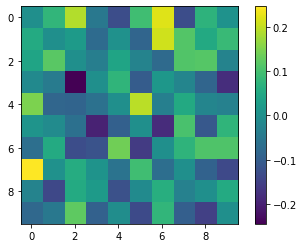

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(W)
plt.colorbar()
plt.show()

それではこの効果を取り入れた新しいコスト関数を用意しましょう。
pyQUBOの形式にするために次のようなコードを書きます。

In [ ]:
cost2 = 0
for i in range(N):
  for j in range(N):
    cost2 = cost2 + W[i][j]*x[i]*x[j]

先程のコスト関数から、今用意した項も追加することにしましょう。

In [ ]:
cost_func2 = cost + cost2 + Placeholder('a')*Constraint(constr, label='Kconstr')

先ほどまで登場した項に対して、さらにもう一つcost2が追加されていますね。
あとはQUBO行列を出力するための準備を整えます。

In [ ]:
model2 = cost_func2.compile()

そしていつも通りQUBO行列の出力をしましょう。

In [ ]:
feed_dict = {'a': 2.0}
qubo2, offset = model2.to_qubo(feed_dict=feed_dict)

どんな答えが出てくるでしょうかね。さすがにわからないですよね。
そうした問題に対しては、量子アニーリングマシンを利用すると良いでしょう。
いつものようにソルバーを指定して、埋め込みをして準備をします。

In [ ]:
dw_sampler = DWaveSampler(solver='Advantage_system1.1', token=token)
sampler = EmbeddingComposite(dw_sampler)

シミュレータを利用したい場合にはOpenJijでOKですね。

In [ ]:
sampler = SQASampler()

これで準備完了です。

In [ ]:
sampleset = sampler.sample_qubo(qubo2,num_reads=10)
print(sampleset.record)

[([0, 0, 0, 1, 0, 1, 0, 0, 0, 1], -20.51305737, 1, 0.)
 ([0, 0, 1, 1, 0, 0, 0, 0, 0, 1], -20.11880306, 2, 0.)
 ([0, 0, 0, 0, 0, 1, 1, 0, 0, 1], -20.04456898, 1, 0.)
 ([0, 1, 1, 0, 0, 0, 0, 0, 1, 0], -19.55954699, 1, 0.)
 ([0, 1, 1, 0, 0, 0, 1, 0, 0, 0], -19.51930286, 3, 0.)
 ([0, 0, 0, 0, 0, 0, 1, 1, 0, 1], -19.22660989, 1, 0.)
 ([1, 0, 1, 1, 0, 0, 0, 0, 0, 1], -18.30759083, 1, 0.)]


先ほどとは異なる結果になったはずです。重さだけでいうと簡単だけど、荷物の組み合わせによって影響が出てくる。
ある荷物を持つと異なる荷物の影響が出てくるといった問題では、量子アニーリングが有効となります。
ポイントは二次関数を利用して、制約条件を課すことで現実的な問題を考える。
そして$x_i$が足し算されるようなただの一次関数だけではなく、
**$x_ix_j$が入った二次関数の問題で、互いの影響を考慮しなければならない問題を考える。**
そこで量子アニーリングの活路が見出されるということになります。

### ポートフォリオ最適化問題

株式銘柄や金融資産を保有する際に、基本的には期待収益と言いますが、
儲かりそうな金融資産を手に入れるというのが基本です。
ただそのときに、自分の予算の限界があり、全てを買うわけにはいかないため、制限があります。
こうした状況で、最適な金融資産の選択を行う問題を**ポートフォリオ最適化問題**と言います。

実際の株式銘柄のデータを活用して、量子アニーリングマシンを利用してこの問題を解いてみましょう。

In [ ]:
import datetime
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2020, 12, 31)

ここではまず株式銘柄のデータをどこからどこまでを利用するかの期間を指定しています。
次に東京証券取引所の証券コードをいくつか選んだリストを用意します。
pythonでは[]の中にカンマ区切りで指定して複数の要素を並べたものをリストと呼びます。

In [ ]:
stockcodes=["2502", "3382", "4661", "6178", "6758", "7203", "8053", "8604", "9020", "9433"]
## アサヒ, セブン&アイ, オリエンタルランド, 日本郵政, ソニー, トヨタ自動車, 住友商事, 野村ホールディングス, JR東日本, KDDI

もちろんこれ以外にもご自身で興味のある証券コードで指定していただいても構いません。
この証券コードで指定された銘柄について、
start時点で購入した株式が、毎日の取引で変動するわけですが、その日の終値をみて、
どれだけの割合増減したのか収益率を調べることにします。
少々長めのfor文を利用したコードとなります。
コード内のコメントで説明しながらにしましょう。

In [ ]:
#証券データの読み込みに利用するライブラリ
import pandas as pd
import pandas_datareader.stooq as stooq

rates = []
#for文で各証券コードについて処理を繰り返していく
for sc in stockcodes:  
  # f"{sc}.jp"で証券を指定して、start,endで始まりと終わりの時期を指定のうえ、.read()読み込みます。その中でも終値だけを知りたいので['Close']としました。
  df = stooq.StooqDailyReader(f"{sc}.jp", start, end).read()[['Close']]

  # pandasのデータフレーム形式で結果を得ることができます。その結果はsort_valuesで日付'Date'で昇順（小さい順）に並べています。
  df = df.sort_values(by='Date',ascending=True)
  
  #前日の終値と今日の終値を比較して、前日比を調べています。
  return_rate = np.zeros(len(df.values))
  for k in range(len(df.values)-1):
    return_rate[k+1] = (df.values[k+1][0] - df.values[k][0])/df.values[k][0]
  
  rates.append(return_rate)

この結果、ratesは、それぞれの証券コードの収益率（前日の終値と当日の終値の差を前日の終値終値との比をとったもの、要するに前の日よりも儲かるかどうか）が格納されたリストが出来上がります。
appendで、結果を次から次へと格納することができます。

これで下準備は終了しました。
その株式銘柄の良さは、平均的な収益率から決められそうですね。
平均的な収益率は大きい方が嬉しいので、先程の荷物の問題と同じです。

In [ ]:
N = len(stockcodes)

w = np.zeros(N)
for k in range(N):
  w[k] = rates[k].mean()

rates[k]から各株式銘柄の収益率の時系列データが出てきます。
それを平均するために、numpyの機能であるmean()を利用しました。
もっとわかりやすくnp.mean(rates[k])としても同じです。

この株式銘柄のうちいくつかを選んで、平均的な収益率を高めるとしましょう。
これまでと同じようにまずは、文字式の準備をしましょう。

In [ ]:
x = Array.create('x', shape=N, vartype='BINARY')

株式銘柄をいくつ選ぶかということを単純にいつもの罰金法を利用して考えてみましょう。

In [ ]:
K = N//2
constr = (sum(x)-K)**2

ここでN//2としたのは、ただの割り算ではなく、偶数でも奇数でも整数の答えを返してくれる計算方法を利用しています。3//2=1、5//2=2といった具合です。割り切れる場合にはただの割り算と同じ（4//2=2）です。
次に収益率を最大化するように選択するために、コスト関数を次のようにします。

In [ ]:
cost = 0
for i in range(N):
  cost = cost - w[i]*x[i]

先ほどまでと同じですね。これで最適化をする準備は整いました。

In [ ]:
cost_func = cost + Placeholder('a')*Constraint(constr, label='Kconstr')
model = cost_func.compile()

これでQUBO行列を書き出す準備が整いました。

In [ ]:
max_coeff = np.max(abs(w))

feed_dict = {'a': 10.0*max_coeff}
qubo, offset = model.to_qubo(feed_dict=feed_dict)

いつもの通りD-Waveマシンを利用する場合には、その準備をしましょう。

In [ ]:
dw_sampler = DWaveSampler(solver='Advantage_system1.1', token=token)
sampler = EmbeddingComposite(dw_sampler)

シミュレータを活用する場合はコチラですね。

In [ ]:
sampler = SQASampler()

In [ ]:
sampleset = sampler.sample_qubo(qubo,num_reads=10)
print(sampleset.record)

[([0, 0, 1, 0, 1, 0, 1, 1, 1, 0], -0.28074252, 1, 0. )
 ([0, 0, 1, 1, 1, 0, 0, 1, 1, 0], -0.28050151, 1, 0. )
 ([0, 0, 0, 1, 1, 1, 1, 1, 0, 0], -0.28027962, 1, 0. )
 ([0, 1, 0, 0, 1, 1, 1, 0, 1, 0], -0.28018786, 1, 0. )
 ([0, 0, 1, 1, 0, 1, 1, 1, 0, 0], -0.27998866, 1, 0. )
 ([0, 1, 1, 1, 0, 0, 1, 1, 0, 0], -0.27955377, 3, 0. )
 ([0, 1, 0, 1, 0, 0, 1, 1, 1, 0], -0.27822792, 1, 0. )
 ([1, 0, 0, 1, 0, 0, 1, 1, 0, 1], -0.27910096, 1, 0.1)]


バッチリとどの株式銘柄が良いかを選んでくれました。
しかしながら、実際の株式市場は複雑です。単純に平均的な指標だけで考えたポートフォリオが安定的に収益を得るかどうかはわかりません。
ある銘柄の収益率が上昇すると、別の銘柄も収益率が上昇するかもしれません。
または下降するかもしれません。そうした関係性を考慮して、もっと良いポートフォリオの組み方があるかもしれません。
そこで荷物のときと同じようにある銘柄を持つと他の銘柄とどのような関係にあるのかを考慮して、コスト関数に組み込んでみましょう。

確率的に変動していく数に対して、その平均からのズレを見てみましょう。
そのズレが大きいほど変動幅は大きいということになります。
こうした平均からのズレの大きさ（二乗で計算する）を足し上げたものを**分散**と言います。
その変動幅が大きいものはリスクを伴う（儲かるかもしれないけど、暴落するかもしれない）ので、それはできることなら避けたいはずです。

またある銘柄で平均からズレたときに、影響して他の銘柄でも平均からズレるかもしれません。
そのズレの積を取ってたしあげたものを**共分散**と言います。
一度下がり始めた場合に、同じように下がるようなものは共分散の値が正の値とります。
それは一緒に崖から落ちるようなものなので、避けたいです。選びたくないです。
そうした考えから次のようなコスト関数を追加することを思いつきます。
\begin{equation}
\sum_{i=1}^N \sum_{j=1}^N W_{ij} x_i x_j
\end{equation}
ここで$W_{ij}$は分散・共分散行列となります。
こうして定式化されたポートフォリオ最適化問題は、Markowitzの現代ポートフォリオ理論の基本的な手法の一つとなっています。

In [ ]:
cost2 = 0
for i in range(N):
  for j in range(N):
    cost2 = cost2 +x[i]*x[j]*np.sum((rates[i]-w[i])*(rates[j]-w[j]))/len(rates[i])

これを足した新しいコスト関数でリスクの最小化も考慮したポートフォリオを設計することができます。

In [ ]:
cost_func2 = cost2 + Placeholder('a')*Constraint(constr, label='Kconstr')
model2 = cost_func2.compile()

QUBO行列を出力する準備が整いました。

In [ ]:
max_coeff = np.max(abs(w))

feed_dict = {'a': 10.0*max_coeff}
qubo2, offset = model2.to_qubo(feed_dict=feed_dict)

この後の流れもお手の物ですね。D-Waveマシンのうちどれを使うかを選び、埋め込みの準備をする。

In [ ]:
dw_sampler = DWaveSampler(solver='Advantage_system1.1', token=token)
sampler = EmbeddingComposite(dw_sampler)

お値段のかからないシミュレータを使いたい場合はコチラ（マシンタイム使い切ってしまった場合もコチラ！）

In [ ]:
sampler = SQASampler()

QUBO行列を投じて、それでは問題を解いてみましょう。

In [ ]:
sampleset = sampler.sample_qubo(qubo2,num_reads=10)
print(sampleset.record)

[([0, 1, 0, 1, 0, 1, 0, 0, 1, 1], -0.27644783, 1, 0.)
 ([1, 1, 1, 1, 0, 0, 0, 0, 0, 1], -0.27628292, 1, 0.)
 ([0, 1, 0, 0, 1, 0, 1, 0, 1, 1], -0.27626747, 1, 0.)
 ([0, 0, 1, 0, 1, 0, 0, 1, 1, 1], -0.27596826, 1, 0.)
 ([1, 1, 1, 1, 0, 0, 1, 0, 0, 0], -0.27593477, 1, 0.)
 ([1, 0, 1, 1, 0, 0, 1, 0, 1, 0], -0.27574202, 1, 0.)
 ([1, 0, 0, 0, 1, 0, 0, 1, 1, 1], -0.2757227 , 1, 0.)
 ([1, 0, 1, 0, 1, 1, 1, 0, 0, 0], -0.27563545, 1, 0.)
 ([1, 0, 1, 0, 1, 1, 0, 0, 1, 0], -0.27560824, 1, 0.)
 ([1, 1, 1, 0, 0, 0, 1, 0, 1, 0], -0.27545233, 1, 0.)]


先ほどから入れ替わったものもあれば、そのまま利用される株式銘柄もあり、味わい深い結果になったかと思います。
実際の運用に活かしてみてはいかがでしょうか？


コードサンプル提供（東北大学大学院情報科学研究科・井口大輔・渡辺大地）